# Lab 7: Introduction to Mining Stream Data

Stream:
- Continuous arrival of events into the future
- Usually cannot store the entire history

In this lab, we will focus on two concepts from lecture. First, we will implement Reservoir Sampling on Twitter data. Then, we will turn our focus to filtering streams using Bloom Filters with an example of email addresses.

In [ ]:
import json
from collections import Counter
import random
%pip install mmh3
import mmh3
import numpy as np
%pip install faker
from faker import Faker
import math
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.6/72.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
GOOGLE_PATH_PREFIX = "drive/MyDrive/SI671-23FALL/Lab 7/"

### 1. Sampling from a Data Stream

With fixed proportion sampling, the size of the sample will continue to grow with the size of the stream. If we have a large stream, we will quickly run out of memory if we use this approach to obtain a sample. Instead, we can use  Reservoir Sampling. The idea is to maintain a set of *s* candidates in the reservoir, which form a true random sample of the elements seen so far in the stream. As the data stream flows, every new element has a certain probability (s/n) of replacing an old element in the reservoir.

To implement Reservoir Sampling, we must:

    • 1. Store all the first s elements of the stream to S
    • 2. Then, suppose we have seen n-1 elements, and now the nth element arrives (n > s):
        • With probability s/n, keep the nth element, else discard it
        • If we picked the nth element, then it replaces one of the s elements in the sample S, picked uniformly at random

As an example, we will apply this to Twitter data about the University of Michigan. We will consider our 'stream' to be data from five consequence days (3/8/2021-3/12/2021) and will assess how the distribution of hashtags used changes with our sample. See below for the code used to obtain the data using the Twitter API.

In [ ]:
# load the data

with open(GOOGLE_PATH_PREFIX + 'tweets_3_08.json', 'r') as f:
    tweets_2021_03_08 = json.load(f)
print("Number of tweets for 3/08/2021:", len(tweets_2021_03_08))

with open(GOOGLE_PATH_PREFIX + 'tweets_3_09.json', 'r') as f:
    tweets_2021_03_09 = json.load(f)
print("Number of tweets for 3/09/2021:", len(tweets_2021_03_09))

with open(GOOGLE_PATH_PREFIX + 'tweets_3_10.json', 'r') as f:
    tweets_2021_03_10 = json.load(f)
print("Number of tweets for 3/10/2021:", len(tweets_2021_03_10))

with open(GOOGLE_PATH_PREFIX + 'tweets_3_11.json', 'r') as f:
    tweets_2021_03_11 = json.load(f)
print("Number of tweets for 3/11/2021:", len(tweets_2021_03_11))

with open(GOOGLE_PATH_PREFIX + 'tweets_3_12.json', 'r') as f:
    tweets_2021_03_12 = json.load(f)
print("Number of tweets for 3/12/2021:", len(tweets_2021_03_12))

Number of tweets for 3/08/2021: 100
Number of tweets for 3/09/2021: 100
Number of tweets for 3/10/2021: 100
Number of tweets for 3/11/2021: 100
Number of tweets for 3/12/2021: 100


In [ ]:
# Reservoir Sampling function

random.seed(721) # for reproducibility

def reservoir_sampling(stream, sample_size, n, current_sample=[]):
    # stream - the new, incoming stream elements
    # sample_size - number of elements we want in our sample
    # n - # of stream elements that we have already looked through (in total)
    # current_sample - the elements currently in our sample

    sample = current_sample # initalize sample to empty list or current sample (before stream arrived)

    for element in stream: # loop through elements
        n = n + 1
        if len(sample) < sample_size: # add element until sample size is at least specified fixed size
            sample.append(stream[element])
        else: # sample is "full"
            random_int = random.randrange(0, n) # think of this as our 'probability' of adding the new element
            if random_int < sample_size:
                sample[random_int] = stream[element] # replace element

    return sample

In [ ]:
# start with 03/08/2021 - will keep all of the tweets since our sample size is 100

sample1 = reservoir_sampling(tweets_2021_03_08, 100, 0, [])
print("Sample size:", len(sample1)) # check

# look at initial distribution of hashtags

hashtags = []
for tweet in sample1:
    if len(tweet['hashtags']) > 0:
        for hashtag in tweet['hashtags']:
            hashtags.append(hashtag['text'])

print(Counter(hashtags))

Sample size: 100
Counter({'GivingBlueday': 3, 'AGTG': 1, 'Librarian': 1, 'jobs': 1, 'opportunity': 1, 'Match2021': 1, 'UofM': 1, 'gunnews': 1, 'marketing': 1, 'highered': 1, 'letterofintent': 1, 'Building': 1, 'Applications': 1, 'Internet': 1, 'History': 1, 'Technology': 1, 'Security': 1})


In [ ]:
# next stream = 03/09/2021 - will now have to start replacing elements

sample2 = reservoir_sampling(tweets_2021_03_09, 100, 100, sample1)
print("Sample size:", len(sample2)) # check

# look at new distribution of hashtags

hashtags = []
for tweet in sample2:
    if len(tweet['hashtags']) > 0:
        for hashtag in tweet['hashtags']:
            hashtags.append(hashtag['text'])

print(Counter(hashtags))

Sample size: 100
Counter({'GivingBlueday': 6, 'Applied': 2, 'Python': 2, 'AGTG': 1, 'University': 1, 'Michigan': 1, 'management': 1, 'Librarian': 1, 'Preparing': 1, 'Graduate': 1, 'Study': 1, 'U': 1, 'Match2021': 1, 'python': 1, 'pythonBasics': 1, 'UX': 1, 'Social': 1, 'Network': 1, 'Analysis': 1, 'Mining': 1, 'GivingBlueDay': 1, 'gunnews': 1, 'letterofintent': 1, 'Internet': 1, 'History': 1, 'Technology': 1, 'Security': 1})


In [ ]:
# next stream = 03/10/2021

sample3 = reservoir_sampling(tweets_2021_03_10, 100, 200, sample2)
print("Sample size:", len(sample3)) # check

# look at new distribution of hashtags

hashtags = []
for tweet in sample3:
    if len(tweet['hashtags']) > 0:
        for hashtag in tweet['hashtags']:
            hashtags.append(hashtag['text'])

print(Counter(hashtags))

Sample size: 100
Counter({'GivingBlueday': 13, 'GivingBlueDay': 2, 'Applied': 2, 'Python': 2, 'AGTG': 1, 'PracticeYourPurpose': 1, 'mentalhealth': 1, 'Preparing': 1, 'Graduate': 1, 'Study': 1, 'U': 1, 'Match2021': 1, 'police': 1, 'ICE': 1, 'python': 1, 'pythonBasics': 1, 'UX': 1, 'Social': 1, 'Network': 1, 'Analysis': 1, 'Mining': 1, 'gunnews': 1})


In [ ]:
# next stream = 03/11/2021

sample4 = reservoir_sampling(tweets_2021_03_11, 100, 300, sample3)
print("Sample size:", len(sample4)) # check

# look at new distribution of hashtags

hashtags = []
for tweet in sample4:
    if len(tweet['hashtags']) > 0:
        for hashtag in tweet['hashtags']:
            hashtags.append(hashtag['text'])

print(Counter(hashtags))

Sample size: 100
Counter({'GivingBlueday': 12, 'Applied': 2, 'Python': 2, 'AGTG': 1, 'PracticeYourPurpose': 1, 'mentalhealth': 1, 'Preparing': 1, 'Graduate': 1, 'Study': 1, 'U': 1, 'Caregiver': 1, 'AfricanAmerican': 1, 'Seniors': 1, 'Dementia': 1, 'Introduction': 1, 'Lean': 1, 'SixSigma': 1, 'police': 1, 'ICE': 1, 'python': 1, 'pythonBasics': 1, 'UX': 1, 'Poshmark': 1, 'OTD': 1, 'Social': 1, 'Network': 1, 'Analysis': 1, 'Mining': 1, 'GivingBlueDay': 1, 'gunnews': 1})


In [ ]:
### YOUR CODE: apply the reservoir_sampling function to add tweets_2021_03_12 to our stream/sample
### What does the final distribution of hashtags look like? How has it changed over time?
### What is the distribution of the days in our final sample (i.e., how many tweets from each day)?




In [ ]:
### EXAMPLE ANSWER

sample5 = reservoir_sampling(tweets_2021_03_12, 100, 400, sample4)
print("Sample size:", len(sample5)) # check

# look at final distribution of hashtags

hashtags = []
for tweet in sample5:
    if len(tweet['hashtags']) > 0:
        for hashtag in tweet['hashtags']:
            hashtags.append(hashtag['text'])

print(Counter(hashtags), "\n")

# look at distirbution of days in our final sample

timestamps = []
for tweet in sample5:
    timestamps.append(tweet['timestamp'])

days = [timestamp[0:10] for timestamp in timestamps]
print(Counter(days))

Sample size: 100
Counter({'GivingBlueday': 10, 'AGTG': 1, 'PracticeYourPurpose': 1, 'mentalhealth': 1, 'Preparing': 1, 'Graduate': 1, 'Study': 1, 'U': 1, 'Caregiver': 1, 'AfricanAmerican': 1, 'Seniors': 1, 'Dementia': 1, 'healthed': 1, 'AcademicTwitter': 1, 'Introduction': 1, 'Lean': 1, 'SixSigma': 1, 'police': 1, 'ICE': 1, 'GoBlue': 1, 'UX': 1, 'Poshmark': 1, 'USA': 1, 'Michigan': 1, 'Applied': 1, 'Social': 1, 'Network': 1, 'Analysis': 1, 'Python': 1, 'GivingBlueDay': 1, 'gunnews': 1}) 

Counter({'Fri Mar 12': 21, 'Wed Mar 10': 21, 'Mon Mar 08': 20, 'Thu Mar 11': 20, 'Tue Mar 09': 18})


The above example demonstrates how we can continue to obtain a sample with a fixed-size (100 in this case) by using Reservoir Sampling. Using such an approach, we can see how the distribution of the stream changes over time. In this case, we saw how the distribution of certain hashtags changed as we progressed through the week of data. Overall, we see that a lot of the tweets use hashtags related to GivingBlueDay which occurred on 3/10/2021. Also, we see that in our final sample, we have an approximately even distribution of tweets across the five days (we would expect this to even out even more if our sample was larger). Therefore, our final sample should be relatively representative of tweets from the week.

### 2. Filtering Data Streams

We can think of each element of a data stream as a tuple. Then, given a list of keys S, we want to be able to determine which tuples of the stream are in S. For example, we may have a list of "good" email addresses that we want to keep and the rest we will treat as spam. To do so, we will implement a Bloom Filter for which we will use k independent hash functions that will map to a single array, B.

In [ ]:
# source: https://www.kdnuggets.com/2016/08/gentle-introduction-bloom-filter.html

class BloomFilter(set):

    # intialize the bloom filter
    def __init__(self, array_size, hash_count):
        super(BloomFilter, self).__init__()
        self.bit_array = np.zeros(array_size) # set B to all zeros
        self.array_size = array_size
        self.hash_count = hash_count

    # hash element (in S) to the array using the hash functions
    def add(self, element):
        for hash_func in range(self.hash_count): # loop through hash functions
            index = mmh3.hash(element, hash_func) % self.array_size # apply hash function to element
            self.bit_array[index] = 1 # set result to 1
        return self

    # function for checking if a stream element is in S
    def __contains__(self, element):
        in_stream = True # default = element is in S
        for hash_func in range(self.hash_count): # loop through hash functions
            index = mmh3.hash(element, hash_func) % self.array_size # apply hash function to element
            if self.bit_array[index] == 0:
                in_stream = False # element not in S
        return in_stream

In [ ]:
# generate our data

fake = Faker()

# generate 1,000 'good' email addresses
good_emails = []
for i in range(1000):
    good_emails.append(fake.email())

# generate 1,000 'spam' email addresses
spam_emails = []
for i in range(1000):
    spam_emails.append(fake.email())

In [ ]:
# example: initalize Bloom Filter with size of array = 10000 and # of hash functions = 10

bloom = BloomFilter(10000, 10)

for email in good_emails: # add our good emails/assign to bits using hash functions
    bloom.add(email)

# check - all 'good' emails should be in S
for email in good_emails:
    if email in bloom:
        pass
    else:
        print("We have an issue... (i.e., false negative)")

Good, no false negatives! Now let's try out some different numbers for k, the number of hash functions, and see how it relates to the false positive rate for our "spam" emails.

In [ ]:
k_list = [2,3,4,5,6,7,8,9,10,11,12] # list of number of hash functions we will loop through
false_positive_rates_estimated = []
false_positive_rates_actual = []

for k in k_list:
    m = len(good_emails)
    n = 10000 # size of array
    bloom = BloomFilter(n, k)

    for email in good_emails: # add our good emails/assign to bits using hash function
        bloom.add(email)

    estimated_fp_rate = (1 - math.exp((-k*m)/n))**k # estimate/calculate the false positive rate
    false_positive_rates_estimated.append(estimated_fp_rate)

    # calculate the actual ('observed') false positive rate
    false_positive_count = 0
    for email in spam_emails: # for each 'spam' email, see if it is in S
        if email in bloom:
            false_positive_count += 1
    false_positive_rate = false_positive_count/len(spam_emails)
    false_positive_rates_actual.append(false_positive_rate)

    print("k={}: Estimated False Positive rate = {}, Actual false positive rate = {}".format(k,
                                                            round(estimated_fp_rate,3), false_positive_rate))

k=2: Estimated False Positive rate = 0.033, Actual false positive rate = 0.049
k=3: Estimated False Positive rate = 0.017, Actual false positive rate = 0.019
k=4: Estimated False Positive rate = 0.012, Actual false positive rate = 0.019
k=5: Estimated False Positive rate = 0.009, Actual false positive rate = 0.017
k=6: Estimated False Positive rate = 0.008, Actual false positive rate = 0.013
k=7: Estimated False Positive rate = 0.008, Actual false positive rate = 0.013
k=8: Estimated False Positive rate = 0.008, Actual false positive rate = 0.011
k=9: Estimated False Positive rate = 0.009, Actual false positive rate = 0.014
k=10: Estimated False Positive rate = 0.01, Actual false positive rate = 0.014
k=11: Estimated False Positive rate = 0.012, Actual false positive rate = 0.019
k=12: Estimated False Positive rate = 0.014, Actual false positive rate = 0.021


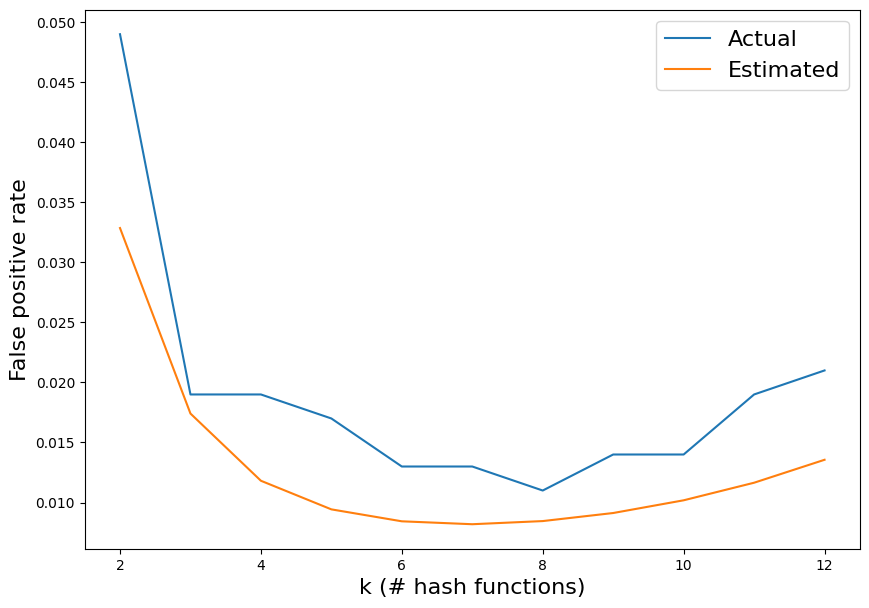

In [ ]:
# plot the results
plt.figure(figsize=(10,7))
plt.plot(k_list, false_positive_rates_actual, label="Actual")
plt.plot(k_list, false_positive_rates_estimated, label = "Estimated")
plt.xlabel("k (# hash functions)", fontsize=16)
plt.ylabel("False positive rate", fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [ ]:
# does this match our optimal value of k using the formula: n/m ln(2) ?

optimal_k = round((n/m) * np.log(2))
print("Optimal value of k (calculated):", optimal_k)

Optimal value of k (calculated): 7


Overall, we see that the Bloom Filter approach guarantees no false negatives with varying false positive rates depending on the number of hash functions. We see that the actual false positive rates mirror the estimated/calculated false positive rates and that the calculated optimal value of k (7 in this case) reflects the results we saw.

In [ ]:
### YOUR CODE: how does changing the size of the array impact the false positive rate?
### follow-up Q: is this what you expected?



array size=4000: Estimated False Positive rate = 0.263, Actual false positive rate = 0.235
array size=6000: Estimated False Positive rate = 0.073, Actual false positive rate = 0.07
array size=8000: Estimated False Positive rate = 0.023, Actual false positive rate = 0.023
array size=10000: Estimated False Positive rate = 0.008, Actual false positive rate = 0.013
array size=12000: Estimated False Positive rate = 0.003, Actual false positive rate = 0.009
array size=14000: Estimated False Positive rate = 0.001, Actual false positive rate = 0.006
array size=16000: Estimated False Positive rate = 0.001, Actual false positive rate = 0.006


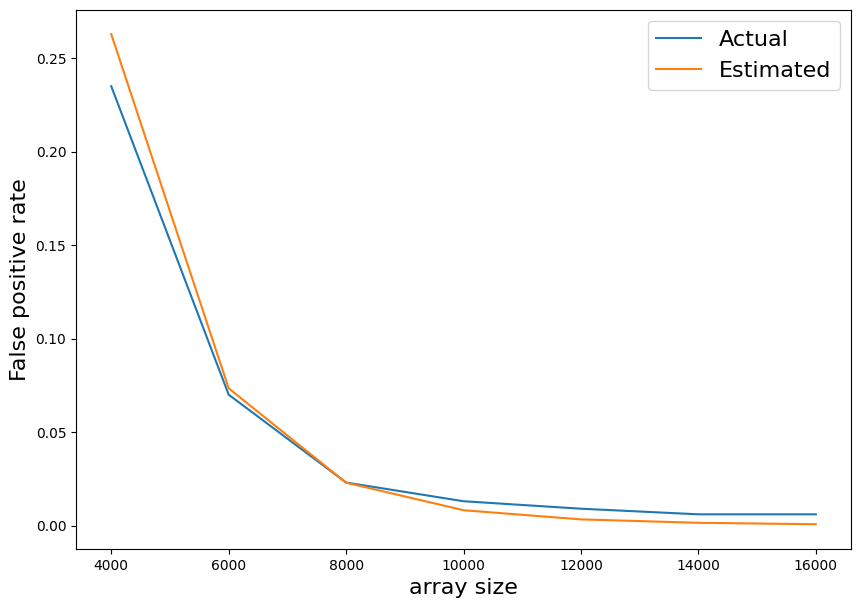

In [ ]:
### EXAMPLE ANSWER

array_sizes = [4000, 6000, 8000, 10000, 12000, 14000, 16000]
false_positive_rates_estimated = []
false_positive_rates_actual = []

for n in array_sizes:
    m = len(good_emails)
    k = 7
    bloom = BloomFilter(n, k)

    for email in good_emails: # add our good emails/assign to bits using hash function
        bloom.add(email)

    estimated_fp_rate = (1 - math.exp((-k*m)/n))**k # estimate/calculate the false positive rate
    false_positive_rates_estimated.append(estimated_fp_rate)

    # calculate the actual 'seen' false positive rate
    false_positive_count = 0
    for email in spam_emails: # for each 'spam' email, see if it is in S
        if email in bloom:
            false_positive_count += 1
    false_positive_rate = false_positive_count/len(spam_emails)
    false_positive_rates_actual.append(false_positive_rate)


    print("array size={}: Estimated False Positive rate = {}, Actual false positive rate = {}".format(n,
                                                            round(estimated_fp_rate,3), false_positive_rate))

# plot the results
plt.figure(figsize=(10,7))
plt.plot(array_sizes, false_positive_rates_actual, label="Actual")
plt.plot(array_sizes, false_positive_rates_estimated, label = "Estimated")
plt.xlabel("array size", fontsize=16)
plt.ylabel("False positive rate", fontsize=16)
plt.legend(fontsize=16)
plt.show()

Note: due to randomness in some of the functions used in this lab, you can expect to get slightly different results each run.